### Long Short-Term Memory Model (LSTM)

In this notebook, we will attempt to train a simple LSTM model on our IMDB movie reviews dataset and see how it performs.

Loading the dataset.

In [1]:
import pandas as pd

# load train dataset
train_df = pd.read_csv('data/train_set.csv')
# load test dataset
test_df = pd.read_csv('data/test_set.csv')

X_train = train_df['text']
y_train = train_df['sentiment']

X_test = test_df['text']
y_test = test_df['sentiment']

In [2]:
import numpy as np
import itertools
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import StratifiedKFold

Preprocessing our movie review text and padding based on max_length identified in the CNN notebook.

In [3]:
# set up preprocessing parameters
vocab_size = 10000 # vocab size that covers 10k most frequent words in our dataset
max_length = 200 # mean length is about 120+ words so we set max to 200

# initialise and fit tokenizer on trainig data
tokenizer = Tokenizer(num_words=vocab_size, oov_token='<OOV>') # adding OOV to hadnle words not in vocab
tokenizer.fit_on_texts(X_train)

# convert move review text to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# pad sequences to ensure all reviews are of uniform length
X_train_pad = pad_sequences(X_train_seq, maxlen=max_length, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_length, padding='post', truncating='post')

Building a simple LSTM architecture using bidirectional LSTM.

In [ ]:
# define LSTM model
def build_lstm_model(vocab_size, embedding_dim, max_length, lstm_units=64, dropout_rate=0.2):
    # Using Bidirectional LSTM often helps capture context better in NLP tasks
    print(f"  Building LSTM with embedding_dim={embedding_dim}, lstm_units={lstm_units}")
    model = models.Sequential([
        layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),
        # Use Bidirectional wrapper around LSTM layer
        layers.Bidirectional(layers.LSTM(units=lstm_units)), # Use lstm_units parameter
        layers.Dropout(dropout_rate), # Add dropout for regularization
        layers.Dense(64, activation='relu'), # Intermediate dense layer
        layers.Dense(1, activation='sigmoid') # Output layer
    ])
    return model

We will then proceed to carry out 5-Fold Cross Validation and simple hyperparameter tuning, considering that training LSTM will take some time due to resource limitations.

In [ ]:
# --- CV Configuration (Same as CNN) ---
N_SPLITS = 5
cv = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=42)

# --- Hyperparameters for LSTM Tuning (Limited Scope) ---
embedding_dims_lstm = [50, 100]     # Same as CNN
lstm_unit_options = [32, 64]        # Number of units in LSTM layer (keep low)
learning_rates_lstm = [0.001, 0.0005]# Same as CNN

# --- Fixed Parameters During CV ---
EPOCHS_CV_LSTM = 15 
BATCH_SIZE_LSTM = 32 # Keep similar to CNN

# Parameters kept fixed
FIXED_VOCAB_SIZE = vocab_size 
FIXED_MAX_LENGTH = max_length 

In [8]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam # Or tf.keras.optimizers.Adam

# --- Initialize Storage ---
lstm_cv_results = []
lstm_misclassified_data = [] # Separate list for LSTM misclassifications

best_lstm_score = -1
best_lstm_params = {}

print("Starting LSTM Cross-Validation with Hyperparameter Tuning...")

# --- Loop through Hyperparameter Combinations ---
lstm_param_combinations = list(itertools.product(embedding_dims_lstm, lstm_unit_options, learning_rates_lstm))
print(f"Total parameter combinations to test: {len(lstm_param_combinations)}")

for combo_idx, (embed_dim, lstm_units, lr) in enumerate(lstm_param_combinations):
    print(f"\n--- Testing Combo {combo_idx+1}/{len(lstm_param_combinations)}: embed={embed_dim}, lstm_units={lstm_units}, lr={lr} ---")
    # Store fold accuracies for calculating mean/std for this combo
    fold_accuracies = []

    # --- Inner loop for Cross-Validation Folds ---
    for fold, (train_idx, val_idx) in enumerate(cv.split(X_train_pad, y_train)):
        # Assumes y_train is already a NumPy array from previous step
        print(f"  Fold {fold + 1}/{N_SPLITS}...")

        # 1. Split data
        X_train_fold, y_train_fold = X_train_pad[train_idx], y_train[train_idx].values
        X_val_fold, y_val_fold = X_train_pad[val_idx], y_train[val_idx].values

        # 2. Rebuild the LSTM model
        lstm_model_fold = build_lstm_model(
            vocab_size=FIXED_VOCAB_SIZE,
            embedding_dim=embed_dim,
            max_length=FIXED_MAX_LENGTH,
            lstm_units=lstm_units
        )

        # 3. Compile the model
        optimizer = Adam(learning_rate=lr)
        lstm_model_fold.compile(optimizer=optimizer,
                                loss='binary_crossentropy',
                                metrics=['accuracy'])

        # 4. Train the model with Early Stopping
        # Patience might need adjustment depending on EPOCHS_CV_LSTM
        early_stopping = EarlyStopping(monitor='val_accuracy', patience=1, restore_best_weights=True, verbose=0)
        history = lstm_model_fold.fit(
            X_train_fold, y_train_fold,
            epochs=EPOCHS_CV_LSTM,
            batch_size=BATCH_SIZE_LSTM,
            validation_data=(X_val_fold, y_val_fold),
            callbacks=[early_stopping],
            verbose=1
        )

        # 5. Evaluate
        loss, accuracy = lstm_model_fold.evaluate(X_val_fold, y_val_fold, batch_size=BATCH_SIZE_LSTM, verbose=0)
        fold_accuracies.append(accuracy)

        # --- 6. Predict & Track First 5 Misclassifications ---
        y_pred_proba_fold = lstm_model_fold.predict(X_val_fold, batch_size=BATCH_SIZE_LSTM)
        y_pred_fold = (y_pred_proba_fold > 0.5).astype(int).flatten()
        misclassified_indices_in_fold = np.where(y_pred_fold != y_val_fold)[0]

        misclassified_count_this_fold = 0
        for local_idx in misclassified_indices_in_fold:
            if misclassified_count_this_fold >= 5:
                break
            original_train_idx = val_idx[local_idx]
            original_text = X_train[original_train_idx]

            misclassified_info = {
                'original_train_index': original_train_idx,
                'fold': fold + 1,
                'embed_dim': embed_dim,
                'lstm_units': lstm_units, # Store relevant LSTM param
                'lr': lr,
                'text': original_text,
                'true_label': int(y_val_fold[local_idx]), # Ensure y_val_fold is NumPy
                'predicted_label': int(y_pred_fold[local_idx]),
                'predicted_probability': float(y_pred_proba_fold[local_idx][0]) # Assumes (N, 1) output shape before flatten
            }
            lstm_misclassified_data.append(misclassified_info)
            misclassified_count_this_fold += 1
        # --- End Misclassification Tracking ---

    # Calculate and store mean accuracy for this hyperparameter combo
    mean_combo_accuracy = np.mean(fold_accuracies)
    std_combo_accuracy = np.std(fold_accuracies)
    print(f"  --- Mean Validation Accuracy: {mean_combo_accuracy:.4f} ± {std_combo_accuracy:.4f} ---") # Print summary

    lstm_cv_results.append({
        'embed_dim': embed_dim, 'lstm_units': lstm_units, 'lr': lr,
        'mean_val_accuracy': mean_combo_accuracy,
        'std_val_accuracy': std_combo_accuracy
    })

    # Track best parameters silently
    if mean_combo_accuracy > best_lstm_score:
        best_lstm_score = mean_combo_accuracy
        best_lstm_params = {'embed_dim': embed_dim, 'lstm_units': lstm_units, 'lr': lr}

    # --- End Hyperparameter Combo Loop ---

Starting LSTM Cross-Validation with Hyperparameter Tuning...
Total parameter combinations to test: 8

--- Testing Combo 1/8: embed=50, lstm_units=32, lr=0.001 ---
  Fold 1/5...
  Building LSTM with embedding_dim=50, lstm_units=32
Epoch 1/15


c:\Users\ander\Desktop\projects\IMDB_sentiment_analysis\it1244\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 37s 35ms/step - accuracy: 0.7294 - loss: 0.5090 - val_accuracy: 0.8674 - val_loss: 0.3186
Epoch 2/15
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 35s 35ms/step - accuracy: 0.9071 - loss: 0.2453 - val_accuracy: 0.8800 - val_loss: 0.3083
Epoch 3/15
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 35s 35ms/step - accuracy: 0.9341 - loss: 0.1798 - val_accuracy: 0.8704 - val_loss: 0.3234
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step
  Fold 2/5...
  Building LSTM with embedding_dim=50, lstm_units=32
Epoch 1/15


c:\Users\ander\Desktop\projects\IMDB_sentiment_analysis\it1244\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 36s 34ms/step - accuracy: 0.7650 - loss: 0.4687 - val_accuracy: 0.8649 - val_loss: 0.3389
Epoch 2/15
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 34s 34ms/step - accuracy: 0.9121 - loss: 0.2350 - val_accuracy: 0.8795 - val_loss: 0.3027
Epoch 3/15
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 34s 34ms/step - accuracy: 0.9374 - loss: 0.1732 - val_accuracy: 0.8842 - val_loss: 0.3166
Epoch 4/15
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 34s 34ms/step - accuracy: 0.9555 - loss: 0.1314 - val_accuracy: 0.8802 - val_loss: 0.3774
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step
  Fold 3/5...
  Building LSTM with embedding_dim=50, lstm_units=32
Epoch 1/15


c:\Users\ander\Desktop\projects\IMDB_sentiment_analysis\it1244\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 36s 34ms/step - accuracy: 0.7581 - loss: 0.4677 - val_accuracy: 0.8774 - val_loss: 0.3109
Epoch 2/15
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 34s 34ms/step - accuracy: 0.9064 - loss: 0.2345 - val_accuracy: 0.8832 - val_loss: 0.2930
Epoch 3/15
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 34s 34ms/step - accuracy: 0.9348 - loss: 0.1784 - val_accuracy: 0.8795 - val_loss: 0.3372
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step
  Fold 4/5...
  Building LSTM with embedding_dim=50, lstm_units=32
Epoch 1/15


c:\Users\ander\Desktop\projects\IMDB_sentiment_analysis\it1244\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 39s 36ms/step - accuracy: 0.7496 - loss: 0.4760 - val_accuracy: 0.8684 - val_loss: 0.3452
Epoch 2/15
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 35s 35ms/step - accuracy: 0.9115 - loss: 0.2369 - val_accuracy: 0.8709 - val_loss: 0.3176
Epoch 3/15
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 35s 35ms/step - accuracy: 0.9411 - loss: 0.1696 - val_accuracy: 0.8748 - val_loss: 0.3231
Epoch 4/15
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 36s 36ms/step - accuracy: 0.9546 - loss: 0.1297 - val_accuracy: 0.8456 - val_loss: 0.4408
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step
  Fold 5/5...
  Building LSTM with embedding_dim=50, lstm_units=32
Epoch 1/15


c:\Users\ander\Desktop\projects\IMDB_sentiment_analysis\it1244\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 39s 37ms/step - accuracy: 0.7493 - loss: 0.4831 - val_accuracy: 0.8771 - val_loss: 0.2945
Epoch 2/15
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 40s 40ms/step - accuracy: 0.9147 - loss: 0.2293 - val_accuracy: 0.8811 - val_loss: 0.2917
Epoch 3/15
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 37s 37ms/step - accuracy: 0.9375 - loss: 0.1693 - val_accuracy: 0.8754 - val_loss: 0.3127
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step
  --- Mean Validation Accuracy: 0.8807 ± 0.0033 ---

--- Testing Combo 2/8: embed=50, lstm_units=32, lr=0.0005 ---
  Fold 1/5...
  Building LSTM with embedding_dim=50, lstm_units=32
Epoch 1/15


c:\Users\ander\Desktop\projects\IMDB_sentiment_analysis\it1244\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 39s 37ms/step - accuracy: 0.7270 - loss: 0.5019 - val_accuracy: 0.8741 - val_loss: 0.3100
Epoch 2/15
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 36s 36ms/step - accuracy: 0.9131 - loss: 0.2339 - val_accuracy: 0.8748 - val_loss: 0.2993
Epoch 3/15
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 37s 37ms/step - accuracy: 0.9375 - loss: 0.1719 - val_accuracy: 0.8799 - val_loss: 0.3401
Epoch 4/15
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 37s 37ms/step - accuracy: 0.9531 - loss: 0.1349 - val_accuracy: 0.8695 - val_loss: 0.3409
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step
  Fold 2/5...
  Building LSTM with embedding_dim=50, lstm_units=32
Epoch 1/15


c:\Users\ander\Desktop\projects\IMDB_sentiment_analysis\it1244\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 40s 37ms/step - accuracy: 0.7246 - loss: 0.5064 - val_accuracy: 0.8711 - val_loss: 0.3085
Epoch 2/15
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 37s 37ms/step - accuracy: 0.9075 - loss: 0.2447 - val_accuracy: 0.8835 - val_loss: 0.2843
Epoch 3/15
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 38s 38ms/step - accuracy: 0.9339 - loss: 0.1836 - val_accuracy: 0.8856 - val_loss: 0.2956
Epoch 4/15
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 37s 37ms/step - accuracy: 0.9502 - loss: 0.1446 - val_accuracy: 0.8771 - val_loss: 0.3285
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step
  Fold 3/5...
  Building LSTM with embedding_dim=50, lstm_units=32
Epoch 1/15


c:\Users\ander\Desktop\projects\IMDB_sentiment_analysis\it1244\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 40s 37ms/step - accuracy: 0.7230 - loss: 0.5014 - val_accuracy: 0.8852 - val_loss: 0.2881
Epoch 2/15
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 36s 36ms/step - accuracy: 0.9121 - loss: 0.2333 - val_accuracy: 0.8885 - val_loss: 0.2901
Epoch 3/15
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 36s 36ms/step - accuracy: 0.9368 - loss: 0.1728 - val_accuracy: 0.8845 - val_loss: 0.3083
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step
  Fold 4/5...
  Building LSTM with embedding_dim=50, lstm_units=32
Epoch 1/15


c:\Users\ander\Desktop\projects\IMDB_sentiment_analysis\it1244\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 38s 36ms/step - accuracy: 0.7135 - loss: 0.5184 - val_accuracy: 0.8719 - val_loss: 0.3236
Epoch 2/15
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 36s 36ms/step - accuracy: 0.9100 - loss: 0.2378 - val_accuracy: 0.8819 - val_loss: 0.3098
Epoch 3/15
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 37s 37ms/step - accuracy: 0.9340 - loss: 0.1853 - val_accuracy: 0.8616 - val_loss: 0.3212
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step
  Fold 5/5...
  Building LSTM with embedding_dim=50, lstm_units=32
Epoch 1/15


c:\Users\ander\Desktop\projects\IMDB_sentiment_analysis\it1244\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 38s 36ms/step - accuracy: 0.7211 - loss: 0.5158 - val_accuracy: 0.8740 - val_loss: 0.3004
Epoch 2/15
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 36s 36ms/step - accuracy: 0.9104 - loss: 0.2380 - val_accuracy: 0.8823 - val_loss: 0.2910
Epoch 3/15
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 36s 36ms/step - accuracy: 0.9381 - loss: 0.1749 - val_accuracy: 0.8646 - val_loss: 0.3243
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step
  --- Mean Validation Accuracy: 0.8836 ± 0.0031 ---

--- Testing Combo 3/8: embed=50, lstm_units=64, lr=0.001 ---
  Fold 1/5...
  Building LSTM with embedding_dim=50, lstm_units=64
Epoch 1/15


c:\Users\ander\Desktop\projects\IMDB_sentiment_analysis\it1244\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 49s 46ms/step - accuracy: 0.7519 - loss: 0.4901 - val_accuracy: 0.8516 - val_loss: 0.3525
Epoch 2/15
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 45s 45ms/step - accuracy: 0.9042 - loss: 0.2538 - val_accuracy: 0.8766 - val_loss: 0.3508
Epoch 3/15
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 45s 45ms/step - accuracy: 0.9306 - loss: 0.1880 - val_accuracy: 0.8635 - val_loss: 0.3302
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step
  Fold 2/5...
  Building LSTM with embedding_dim=50, lstm_units=64
Epoch 1/15


c:\Users\ander\Desktop\projects\IMDB_sentiment_analysis\it1244\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 46s 44ms/step - accuracy: 0.7409 - loss: 0.4934 - val_accuracy: 0.8742 - val_loss: 0.3085
Epoch 2/15
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 43s 43ms/step - accuracy: 0.9049 - loss: 0.2515 - val_accuracy: 0.8866 - val_loss: 0.2877
Epoch 3/15
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 43s 42ms/step - accuracy: 0.9350 - loss: 0.1773 - val_accuracy: 0.8566 - val_loss: 0.3440
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step
  Fold 3/5...
  Building LSTM with embedding_dim=50, lstm_units=64
Epoch 1/15


c:\Users\ander\Desktop\projects\IMDB_sentiment_analysis\it1244\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 45s 42ms/step - accuracy: 0.7386 - loss: 0.5081 - val_accuracy: 0.8644 - val_loss: 0.3230
Epoch 2/15
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 42s 42ms/step - accuracy: 0.9012 - loss: 0.2634 - val_accuracy: 0.8544 - val_loss: 0.3376
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step
  Fold 4/5...
  Building LSTM with embedding_dim=50, lstm_units=64
Epoch 1/15


c:\Users\ander\Desktop\projects\IMDB_sentiment_analysis\it1244\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 43s 41ms/step - accuracy: 0.7419 - loss: 0.5017 - val_accuracy: 0.8671 - val_loss: 0.3256
Epoch 2/15
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 41s 41ms/step - accuracy: 0.9030 - loss: 0.2531 - val_accuracy: 0.8748 - val_loss: 0.3100
Epoch 3/15
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 41s 41ms/step - accuracy: 0.9360 - loss: 0.1802 - val_accuracy: 0.8524 - val_loss: 0.3422
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step
  Fold 5/5...
  Building LSTM with embedding_dim=50, lstm_units=64
Epoch 1/15


c:\Users\ander\Desktop\projects\IMDB_sentiment_analysis\it1244\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 53s 50ms/step - accuracy: 0.7553 - loss: 0.4768 - val_accuracy: 0.6945 - val_loss: 0.5997
Epoch 2/15
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 47s 47ms/step - accuracy: 0.8727 - loss: 0.3182 - val_accuracy: 0.8809 - val_loss: 0.2938
Epoch 3/15
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 49s 49ms/step - accuracy: 0.9298 - loss: 0.1973 - val_accuracy: 0.8679 - val_loss: 0.4721
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
  --- Mean Validation Accuracy: 0.8766 ± 0.0074 ---

--- Testing Combo 4/8: embed=50, lstm_units=64, lr=0.0005 ---
  Fold 1/5...
  Building LSTM with embedding_dim=50, lstm_units=64
Epoch 1/15


c:\Users\ander\Desktop\projects\IMDB_sentiment_analysis\it1244\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 47s 45ms/step - accuracy: 0.7363 - loss: 0.4971 - val_accuracy: 0.8758 - val_loss: 0.3127
Epoch 2/15
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 44s 44ms/step - accuracy: 0.9087 - loss: 0.2421 - val_accuracy: 0.8795 - val_loss: 0.2973
Epoch 3/15
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 45s 45ms/step - accuracy: 0.9321 - loss: 0.1866 - val_accuracy: 0.8789 - val_loss: 0.3135
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step
  Fold 2/5...
  Building LSTM with embedding_dim=50, lstm_units=64
Epoch 1/15


c:\Users\ander\Desktop\projects\IMDB_sentiment_analysis\it1244\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 44s 42ms/step - accuracy: 0.7341 - loss: 0.4881 - val_accuracy: 0.8810 - val_loss: 0.2939
Epoch 2/15
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 41s 41ms/step - accuracy: 0.9132 - loss: 0.2343 - val_accuracy: 0.8864 - val_loss: 0.2995
Epoch 3/15
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 41s 41ms/step - accuracy: 0.9371 - loss: 0.1780 - val_accuracy: 0.8776 - val_loss: 0.3286
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step
  Fold 3/5...
  Building LSTM with embedding_dim=50, lstm_units=64
Epoch 1/15


c:\Users\ander\Desktop\projects\IMDB_sentiment_analysis\it1244\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 50s 47ms/step - accuracy: 0.7324 - loss: 0.4980 - val_accuracy: 0.8625 - val_loss: 0.3323
Epoch 2/15
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 47s 47ms/step - accuracy: 0.9112 - loss: 0.2372 - val_accuracy: 0.8808 - val_loss: 0.3053
Epoch 3/15
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 47s 47ms/step - accuracy: 0.9354 - loss: 0.1798 - val_accuracy: 0.8684 - val_loss: 0.3248
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step
  Fold 4/5...
  Building LSTM with embedding_dim=50, lstm_units=64
Epoch 1/15


c:\Users\ander\Desktop\projects\IMDB_sentiment_analysis\it1244\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 46s 44ms/step - accuracy: 0.7369 - loss: 0.4858 - val_accuracy: 0.8746 - val_loss: 0.2969
Epoch 2/15
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 44s 44ms/step - accuracy: 0.9171 - loss: 0.2192 - val_accuracy: 0.8791 - val_loss: 0.2966
Epoch 3/15
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 43s 43ms/step - accuracy: 0.9350 - loss: 0.1788 - val_accuracy: 0.8764 - val_loss: 0.3544
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step
  Fold 5/5...
  Building LSTM with embedding_dim=50, lstm_units=64
Epoch 1/15


c:\Users\ander\Desktop\projects\IMDB_sentiment_analysis\it1244\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 44s 41ms/step - accuracy: 0.7540 - loss: 0.4723 - val_accuracy: 0.8788 - val_loss: 0.3012
Epoch 2/15
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 41s 41ms/step - accuracy: 0.9133 - loss: 0.2338 - val_accuracy: 0.8781 - val_loss: 0.2975
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step
  --- Mean Validation Accuracy: 0.8809 ± 0.0028 ---

--- Testing Combo 5/8: embed=100, lstm_units=32, lr=0.001 ---
  Fold 1/5...
  Building LSTM with embedding_dim=100, lstm_units=32
Epoch 1/15


c:\Users\ander\Desktop\projects\IMDB_sentiment_analysis\it1244\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 44s 42ms/step - accuracy: 0.7781 - loss: 0.4561 - val_accuracy: 0.8765 - val_loss: 0.3074
Epoch 2/15
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 42s 42ms/step - accuracy: 0.9125 - loss: 0.2316 - val_accuracy: 0.8789 - val_loss: 0.2947
Epoch 3/15
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 42s 42ms/step - accuracy: 0.9397 - loss: 0.1666 - val_accuracy: 0.8661 - val_loss: 0.3185
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step
  Fold 2/5...
  Building LSTM with embedding_dim=100, lstm_units=32
Epoch 1/15


c:\Users\ander\Desktop\projects\IMDB_sentiment_analysis\it1244\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 45s 43ms/step - accuracy: 0.7528 - loss: 0.4873 - val_accuracy: 0.8673 - val_loss: 0.3098
Epoch 2/15
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 42s 42ms/step - accuracy: 0.9110 - loss: 0.2384 - val_accuracy: 0.8736 - val_loss: 0.3393
Epoch 3/15
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 42s 42ms/step - accuracy: 0.9357 - loss: 0.1738 - val_accuracy: 0.8840 - val_loss: 0.3116
Epoch 4/15
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 43s 42ms/step - accuracy: 0.9588 - loss: 0.1186 - val_accuracy: 0.8515 - val_loss: 0.4626
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step
  Fold 3/5...
  Building LSTM with embedding_dim=100, lstm_units=32
Epoch 1/15


c:\Users\ander\Desktop\projects\IMDB_sentiment_analysis\it1244\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 46s 44ms/step - accuracy: 0.7740 - loss: 0.4603 - val_accuracy: 0.8767 - val_loss: 0.3098
Epoch 2/15
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 45s 45ms/step - accuracy: 0.9125 - loss: 0.2396 - val_accuracy: 0.8800 - val_loss: 0.2936
Epoch 3/15
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 45s 45ms/step - accuracy: 0.9368 - loss: 0.1732 - val_accuracy: 0.8710 - val_loss: 0.3811
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step
  Fold 4/5...
  Building LSTM with embedding_dim=100, lstm_units=32
Epoch 1/15


c:\Users\ander\Desktop\projects\IMDB_sentiment_analysis\it1244\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 48s 45ms/step - accuracy: 0.7640 - loss: 0.4665 - val_accuracy: 0.8658 - val_loss: 0.3212
Epoch 2/15
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 43s 43ms/step - accuracy: 0.9059 - loss: 0.2489 - val_accuracy: 0.8771 - val_loss: 0.3086
Epoch 3/15
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 43s 43ms/step - accuracy: 0.9409 - loss: 0.1633 - val_accuracy: 0.8745 - val_loss: 0.3442
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step
  Fold 5/5...
  Building LSTM with embedding_dim=100, lstm_units=32
Epoch 1/15


c:\Users\ander\Desktop\projects\IMDB_sentiment_analysis\it1244\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 45s 43ms/step - accuracy: 0.7610 - loss: 0.4670 - val_accuracy: 0.8684 - val_loss: 0.3127
Epoch 2/15
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 42s 42ms/step - accuracy: 0.9141 - loss: 0.2291 - val_accuracy: 0.8755 - val_loss: 0.3285
Epoch 3/15
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 42s 42ms/step - accuracy: 0.9388 - loss: 0.1649 - val_accuracy: 0.8720 - val_loss: 0.3223
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step
  --- Mean Validation Accuracy: 0.8791 ± 0.0029 ---

--- Testing Combo 6/8: embed=100, lstm_units=32, lr=0.0005 ---
  Fold 1/5...
  Building LSTM with embedding_dim=100, lstm_units=32
Epoch 1/15


c:\Users\ander\Desktop\projects\IMDB_sentiment_analysis\it1244\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 45s 43ms/step - accuracy: 0.7457 - loss: 0.4891 - val_accuracy: 0.8727 - val_loss: 0.3080
Epoch 2/15
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 42s 42ms/step - accuracy: 0.9133 - loss: 0.2283 - val_accuracy: 0.8834 - val_loss: 0.3019
Epoch 3/15
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 42s 42ms/step - accuracy: 0.9379 - loss: 0.1699 - val_accuracy: 0.8706 - val_loss: 0.3321
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step
  Fold 2/5...
  Building LSTM with embedding_dim=100, lstm_units=32
Epoch 1/15


c:\Users\ander\Desktop\projects\IMDB_sentiment_analysis\it1244\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 45s 43ms/step - accuracy: 0.7288 - loss: 0.5004 - val_accuracy: 0.8817 - val_loss: 0.2944
Epoch 2/15
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 43s 43ms/step - accuracy: 0.9124 - loss: 0.2358 - val_accuracy: 0.8801 - val_loss: 0.2851
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step
  Fold 3/5...
  Building LSTM with embedding_dim=100, lstm_units=32
Epoch 1/15


c:\Users\ander\Desktop\projects\IMDB_sentiment_analysis\it1244\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 45s 42ms/step - accuracy: 0.7339 - loss: 0.4893 - val_accuracy: 0.8838 - val_loss: 0.2894
Epoch 2/15
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 42s 42ms/step - accuracy: 0.9145 - loss: 0.2273 - val_accuracy: 0.8831 - val_loss: 0.2938
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step
  Fold 4/5...
  Building LSTM with embedding_dim=100, lstm_units=32
Epoch 1/15


c:\Users\ander\Desktop\projects\IMDB_sentiment_analysis\it1244\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 45s 43ms/step - accuracy: 0.7548 - loss: 0.4685 - val_accuracy: 0.8766 - val_loss: 0.3028
Epoch 2/15
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 43s 43ms/step - accuracy: 0.9167 - loss: 0.2255 - val_accuracy: 0.8715 - val_loss: 0.3021
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step
  Fold 5/5...
  Building LSTM with embedding_dim=100, lstm_units=32
Epoch 1/15


c:\Users\ander\Desktop\projects\IMDB_sentiment_analysis\it1244\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 45s 43ms/step - accuracy: 0.7337 - loss: 0.5016 - val_accuracy: 0.8751 - val_loss: 0.3061
Epoch 2/15
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 42s 42ms/step - accuracy: 0.9120 - loss: 0.2317 - val_accuracy: 0.8838 - val_loss: 0.2973
Epoch 3/15
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 41s 41ms/step - accuracy: 0.9366 - loss: 0.1740 - val_accuracy: 0.8777 - val_loss: 0.3176
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step
  --- Mean Validation Accuracy: 0.8819 ± 0.0027 ---

--- Testing Combo 7/8: embed=100, lstm_units=64, lr=0.001 ---
  Fold 1/5...
  Building LSTM with embedding_dim=100, lstm_units=64
Epoch 1/15


c:\Users\ander\Desktop\projects\IMDB_sentiment_analysis\it1244\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 50s 48ms/step - accuracy: 0.7650 - loss: 0.4700 - val_accuracy: 0.8712 - val_loss: 0.3221
Epoch 2/15
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 48s 48ms/step - accuracy: 0.9099 - loss: 0.2415 - val_accuracy: 0.8719 - val_loss: 0.3127
Epoch 3/15
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 48s 48ms/step - accuracy: 0.9392 - loss: 0.1713 - val_accuracy: 0.8734 - val_loss: 0.3745
Epoch 4/15
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 48s 48ms/step - accuracy: 0.9527 - loss: 0.1297 - val_accuracy: 0.8510 - val_loss: 0.3909
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step
  Fold 2/5...
  Building LSTM with embedding_dim=100, lstm_units=64
Epoch 1/15


c:\Users\ander\Desktop\projects\IMDB_sentiment_analysis\it1244\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 49s 47ms/step - accuracy: 0.7549 - loss: 0.4730 - val_accuracy: 0.8746 - val_loss: 0.2956
Epoch 2/15
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 49s 49ms/step - accuracy: 0.9103 - loss: 0.2417 - val_accuracy: 0.8884 - val_loss: 0.3008
Epoch 3/15
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 49s 49ms/step - accuracy: 0.9364 - loss: 0.1728 - val_accuracy: 0.8777 - val_loss: 0.3359
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step
  Fold 3/5...
  Building LSTM with embedding_dim=100, lstm_units=64
Epoch 1/15


c:\Users\ander\Desktop\projects\IMDB_sentiment_analysis\it1244\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 60s 57ms/step - accuracy: 0.7395 - loss: 0.5031 - val_accuracy: 0.8741 - val_loss: 0.3421
Epoch 2/15
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 55s 55ms/step - accuracy: 0.9046 - loss: 0.2503 - val_accuracy: 0.8717 - val_loss: 0.3147
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step
  Fold 4/5...
  Building LSTM with embedding_dim=100, lstm_units=64
Epoch 1/15


c:\Users\ander\Desktop\projects\IMDB_sentiment_analysis\it1244\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 58s 56ms/step - accuracy: 0.7662 - loss: 0.4783 - val_accuracy: 0.8761 - val_loss: 0.3185
Epoch 2/15
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 59s 59ms/step - accuracy: 0.9091 - loss: 0.2360 - val_accuracy: 0.8469 - val_loss: 0.3767
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step
  Fold 5/5...
  Building LSTM with embedding_dim=100, lstm_units=64
Epoch 1/15


c:\Users\ander\Desktop\projects\IMDB_sentiment_analysis\it1244\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 55s 52ms/step - accuracy: 0.7511 - loss: 0.4908 - val_accuracy: 0.8745 - val_loss: 0.3102
Epoch 2/15
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 50s 50ms/step - accuracy: 0.9038 - loss: 0.2542 - val_accuracy: 0.8619 - val_loss: 0.3225
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step
  --- Mean Validation Accuracy: 0.8773 ± 0.0056 ---

--- Testing Combo 8/8: embed=100, lstm_units=64, lr=0.0005 ---
  Fold 1/5...
  Building LSTM with embedding_dim=100, lstm_units=64
Epoch 1/15


c:\Users\ander\Desktop\projects\IMDB_sentiment_analysis\it1244\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 55s 52ms/step - accuracy: 0.7481 - loss: 0.4724 - val_accuracy: 0.8783 - val_loss: 0.3034
Epoch 2/15
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 51s 51ms/step - accuracy: 0.9148 - loss: 0.2293 - val_accuracy: 0.8786 - val_loss: 0.3016
Epoch 3/15
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 50s 50ms/step - accuracy: 0.9390 - loss: 0.1706 - val_accuracy: 0.8767 - val_loss: 0.3401
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step
  Fold 2/5...
  Building LSTM with embedding_dim=100, lstm_units=64
Epoch 1/15


c:\Users\ander\Desktop\projects\IMDB_sentiment_analysis\it1244\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 65s 62ms/step - accuracy: 0.7397 - loss: 0.4865 - val_accuracy: 0.8826 - val_loss: 0.3054
Epoch 2/15
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 58s 58ms/step - accuracy: 0.9063 - loss: 0.2442 - val_accuracy: 0.8821 - val_loss: 0.3211
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step
  Fold 3/5...
  Building LSTM with embedding_dim=100, lstm_units=64
Epoch 1/15


c:\Users\ander\Desktop\projects\IMDB_sentiment_analysis\it1244\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 60s 57ms/step - accuracy: 0.7546 - loss: 0.4764 - val_accuracy: 0.8689 - val_loss: 0.3213
Epoch 2/15
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 56s 56ms/step - accuracy: 0.9106 - loss: 0.2354 - val_accuracy: 0.8763 - val_loss: 0.3139
Epoch 3/15
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 55s 55ms/step - accuracy: 0.9379 - loss: 0.1737 - val_accuracy: 0.8777 - val_loss: 0.3093
Epoch 4/15
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 55s 55ms/step - accuracy: 0.9580 - loss: 0.1248 - val_accuracy: 0.8677 - val_loss: 0.3606
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step
  Fold 4/5...
  Building LSTM with embedding_dim=100, lstm_units=64
Epoch 1/15


c:\Users\ander\Desktop\projects\IMDB_sentiment_analysis\it1244\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 57s 54ms/step - accuracy: 0.7238 - loss: 0.5070 - val_accuracy: 0.8751 - val_loss: 0.3108
Epoch 2/15
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 52s 52ms/step - accuracy: 0.9122 - loss: 0.2324 - val_accuracy: 0.8756 - val_loss: 0.3429
Epoch 3/15
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 52s 52ms/step - accuracy: 0.9383 - loss: 0.1699 - val_accuracy: 0.8735 - val_loss: 0.3346
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step
  Fold 5/5...
  Building LSTM with embedding_dim=100, lstm_units=64
Epoch 1/15


c:\Users\ander\Desktop\projects\IMDB_sentiment_analysis\it1244\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 63s 60ms/step - accuracy: 0.7454 - loss: 0.4800 - val_accuracy: 0.8636 - val_loss: 0.3366
Epoch 2/15
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 59s 59ms/step - accuracy: 0.9112 - loss: 0.2392 - val_accuracy: 0.8820 - val_loss: 0.2905
Epoch 3/15
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 58s 58ms/step - accuracy: 0.9343 - loss: 0.1769 - val_accuracy: 0.8810 - val_loss: 0.3083
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step
  --- Mean Validation Accuracy: 0.8793 ± 0.0026 ---


In [9]:
lstm_cv_results_df = pd.DataFrame(lstm_cv_results)
lstm_cv_results_df = lstm_cv_results_df.sort_values(by='mean_val_accuracy', ascending=False)
print("\n--- LSTM CV Hyperparameter Tuning Results (Sorted) ---")
print(lstm_cv_results_df)
print("\n--- Best LSTM Hyperparameters Found ---")
print(best_lstm_params)
print(f"Best Mean Cross-Validation Accuracy: {best_lstm_score:.4f}")


--- LSTM CV Hyperparameter Tuning Results (Sorted) ---
   embed_dim  lstm_units      lr  mean_val_accuracy  std_val_accuracy
1         50          32  0.0005           0.883625          0.003059
5        100          32  0.0005           0.881850          0.002715
3         50          64  0.0005           0.880900          0.002819
0         50          32  0.0010           0.880675          0.003322
7        100          64  0.0005           0.879325          0.002635
4        100          32  0.0010           0.879100          0.002889
6        100          64  0.0010           0.877300          0.005610
2         50          64  0.0010           0.876650          0.007371

--- Best LSTM Hyperparameters Found ---
{'embed_dim': 50, 'lstm_units': 32, 'lr': 0.0005}
Best Mean Cross-Validation Accuracy: 0.8836


From the results, the LSTM model achieve a best mean average accuracy of **88.36%**, with a small standard deviation (all <= **±0.0074**). This suggests that the model's performance is consistent accross folds, which is a good sign of performance as well.

In [13]:
# analyse misclassified data
misclassified_df = pd.DataFrame(lstm_misclassified_data)
misclassified_df = misclassified_df.sort_values(by='predicted_probability', ascending=True)

# taking a look at a sample at random (display only specific columns)
print("\n--- Sample of Misclassified Data ---")
sample_misclassified = pd.DataFrame(misclassified_df[['text', 'true_label', 'predicted_label', 'predicted_probability']].sample(5))
for i in range(len(sample_misclassified)):
    print(f"Text: {sample_misclassified.iloc[i]['text']}")
sample_misclassified


--- Sample of Misclassified Data ---
Text: saw chance show cable want like think sandra quite funny remember facial movement throughout movie jaw drop stun awful movie suffer throughthe person say one funny movie time please point one line one scene even worth chuckleshe much good singer remember not want watch lounge acti think movie try hard like since think not view objectively
Text: saw chance show cable want like think sandra quite funny remember facial movement throughout movie jaw drop stun awful movie suffer throughthe person say one funny movie time please point one line one scene even worth chuckleshe much good singer remember not want watch lounge acti think movie try hard like since think not view objectively
Text: rented movie day love romance story get bad one ever see life find hard believe sam would fall love kelley say hardly no 2 word great longtime boyfriend devote completely think kelley major jerk throughout movie never change good thing movie josh hartnett think 

,text,true_label,predicted_label,predicted_probability
171,saw chance show cable want like think sandra q...,0,1,0.699180
21,saw chance show cable want like think sandra q...,0,1,0.526419
56,rented movie day love romance story get bad on...,0,1,0.647070
27,movie lot blood sabretooth attack also love gu...,0,1,0.820384
106,rule full moon production logo warn sign avoid...,1,0,0.251571


LSTM doesn't using a sliding window kernel like CNN but processes sequences step-by-step. In the misclassification examples above, it looks like the model might have focused on the positive adjectives while ignoring contextual clues like sarcasm or fragmented structure for the reviews that it wrongly classified as positive. Therefore, it is unable to capture the full semantic context since it relies on order of tokens rather than global context of the entire sequence.

Now that we are confident that LSTM is a good model choice, we will proceed to train it using the hyperparameters identified.

In [10]:
# Use parameters found from CV
final_embed_dim_lstm = best_lstm_params['embed_dim']
final_lstm_units = best_lstm_params['lstm_units']
final_lr_lstm = best_lstm_params['lr']

EPOCHS_FINAL_LSTM = 5 # from CV, most epochs were between 3-5
PATIENCE_FINAL_LSTM = 2

final_lstm_model = build_lstm_model(
    vocab_size=FIXED_VOCAB_SIZE,
    embedding_dim=final_embed_dim_lstm,
    max_length=FIXED_MAX_LENGTH,
    lstm_units=final_lstm_units
)

final_lstm_model.compile(optimizer=Adam(learning_rate=final_lr_lstm),
                        loss='binary_crossentropy',
                        metrics=['accuracy'])

# early stopping for final model
early_stopping_final = EarlyStopping(
    monitor='loss', 
    patience=PATIENCE_FINAL_LSTM, restore_best_weights=True, verbose=0)

final_lstm_model.fit(
    X_train_pad, y_train.values,
    epochs=EPOCHS_FINAL_LSTM,
    batch_size=BATCH_SIZE_LSTM,
    callbacks=[early_stopping_final],
    verbose=1
)

  Building LSTM with embedding_dim=50, lstm_units=32
Epoch 1/5


c:\Users\ander\Desktop\projects\IMDB_sentiment_analysis\it1244\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 42s 32ms/step - accuracy: 0.7495 - loss: 0.4754
Epoch 2/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 40s 32ms/step - accuracy: 0.9157 - loss: 0.2239
Epoch 3/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 40s 32ms/step - accuracy: 0.9364 - loss: 0.1741
Epoch 4/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 40s 32ms/step - accuracy: 0.9486 - loss: 0.1396
Epoch 5/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 40s 32ms/step - accuracy: 0.9576 - loss: 0.1196


In [12]:
final_lstm_model.save('dl_models/final_lstm_model.keras')

We will then proceed to evaluate the model on the unseen test data and determine its performance based on common classification metrics.

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report,
    roc_curve,
    auc,
    precision_recall_curve,
    average_precision_score
)

In [15]:
def plot_evaluation_summary(y_true, y_pred_proba, cm, model_name="Model"):
    """Generates a figure with insightful evaluation plots."""

    fig, axes = plt.subplots(2, 2, figsize=(14, 12))
    fig.suptitle(f'Evaluation Summary for {model_name}', fontsize=16)

    # 1. Confusion Matrix (Raw Counts)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0, 0],
                xticklabels=['Predicted Neg (0)', 'Predicted Pos (1)'],
                yticklabels=['True Neg (0)', 'True Pos (1)'])
    axes[0, 0].set_title('Confusion Matrix (Counts)')
    axes[0, 0].set_ylabel('True Label')
    axes[0, 0].set_xlabel('Predicted Label')

    # 2. ROC Curve 
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    axes[0, 1].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
    axes[0, 1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    axes[0, 1].set_xlim([0.0, 1.0])
    axes[0, 1].set_ylim([0.0, 1.05])
    axes[0, 1].set_xlabel('False Positive Rate')
    axes[0, 1].set_ylabel('True Positive Rate')
    axes[0, 1].set_title('Receiver Operating Characteristic (ROC)')
    axes[0, 1].legend(loc="lower right")
    axes[0, 1].grid(alpha=0.3)

    # 3. Precision-Recall Curve 
    precision, recall, _ = precision_recall_curve(y_true, y_pred_proba)
    pr_auc = average_precision_score(y_true, y_pred_proba)
    axes[1, 0].plot(recall, precision, color='skyblue', lw=2, label=f'PR curve (AP = {pr_auc:.3f})')
    pos_proportion = np.mean(y_true)
    axes[1, 0].axhline(pos_proportion, color='grey', lw=1, linestyle='--', label=f'Baseline ({pos_proportion:.2f})')
    axes[1, 0].set_xlim([0.0, 1.0])
    axes[1, 0].set_ylim([0.0, 1.05])
    axes[1, 0].set_xlabel('Recall (Sensitivity)')
    axes[1, 0].set_ylabel('Precision')
    axes[1, 0].set_title('Precision-Recall Curve')
    axes[1, 0].legend(loc="lower left")
    axes[1, 0].grid(alpha=0.3)

    # 4. Distribution of Predicted Probabilities (Using KDE Plot)
    neg_probs = y_pred_proba[y_true == 0]
    pos_probs = y_pred_proba[y_true == 1]
    sns.kdeplot(neg_probs, color="red", fill=True, alpha=0.5, label='True Negative (0)', ax=axes[1, 1], lw=2)
    sns.kdeplot(pos_probs, color="blue", fill=True, alpha=0.5, label='True Positive (1)', ax=axes[1, 1], lw=2)
    axes[1, 1].axvline(0.5, color='grey', linestyle='--', lw=1, label='Threshold (0.5)')
    axes[1, 1].set_title('Distribution of Predicted Probabilities (KDE)') # Updated title
    axes[1, 1].set_xlabel('Predicted Probability of Positive Class (1)')
    axes[1, 1].set_ylabel('Density')
    # Adjust xlim slightly if peaks are cut off right at 0/1
    axes[1, 1].set_xlim([-0.05, 1.05])
    axes[1, 1].legend()
    axes[1, 1].grid(alpha=0.3)

    plt.tight_layout(rect=[0, 0.03, 1, 0.97])

    return fig


In [16]:
def evaluate_sequential_model(model, X_test_pad, y_test, model_name="Sequential Model", batch_size=32, threshold=0.5):
    print(f"--- Evaluating {model_name} ---")

    # Ensure y_test is NumPy 
    if not isinstance(y_test, np.ndarray):
        y_test = np.array(y_test)

    # Predict probabilities
    print(f"Predicting probabilities using batch size {batch_size}...")
    try:
        y_pred_proba = model.predict(X_test_pad, batch_size=batch_size, verbose=1)
    except Exception as e:
        print(f"Error during prediction: {e}")
        return None, None

    # Ensure predictions are flattened correctly
    y_pred_proba = y_pred_proba.flatten()

    # Convert probabilities to binary labels
    y_pred_label = (y_pred_proba >= threshold).astype(int)

    # Calculate Metrics
    print("\nCalculating Metrics...")
    accuracy = accuracy_score(y_test, y_pred_label)
    cm = confusion_matrix(y_test, y_pred_label)
    # Ensure target names match label encoding (0: Neg, 1: Pos)
    report_str = classification_report(y_test, y_pred_label, target_names=['Negative (0)', 'Positive (1)'])
    report_dict = classification_report(y_test, y_pred_label, target_names=['Negative (0)', 'Positive (1)'], output_dict=True)
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    pr_auc = average_precision_score(y_test, y_pred_proba)

    # Store Results
    results = {
        'model_name': model_name,
        'accuracy': accuracy,
        'roc_auc': roc_auc,
        'pr_auc (Average Precision)': pr_auc,
        'confusion_matrix': cm.tolist(),
        'classification_report_str': report_str,
        'classification_report_dict': report_dict,
    }

    # Print Key Metrics
    print("\n--- Key Performance Metrics ---")
    print(f"Accuracy: {results['accuracy']:.4f}")
    print(f"ROC AUC: {results['roc_auc']:.4f}")
    print(f"PR AUC (Avg Precision): {results['pr_auc (Average Precision)']:.4f}")
    print(f"\nConfusion Matrix:\n{cm}")
    print("\nClassification Report:")
    print(results['classification_report_str'])

    # Generate Plots using the separate plotting function
    print("\nGenerating Evaluation Plots...")
    fig = plot_evaluation_summary(y_test, y_pred_proba, cm, model_name)

    print(f"--- Evaluation Complete for {model_name} ---")

    return results, fig

--- Evaluating LSTM ---
Predicting probabilities using batch size 32...
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step

Calculating Metrics...

--- Key Performance Metrics ---
Accuracy: 0.8756
ROC AUC: 0.9390
PR AUC (Avg Precision): 0.9330

Confusion Matrix:
[[4413  587]
 [ 657 4343]]

Classification Report:
              precision    recall  f1-score   support

Negative (0)       0.87      0.88      0.88      5000
Positive (1)       0.88      0.87      0.87      5000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000


Generating Evaluation Plots...
--- Evaluation Complete for LSTM ---


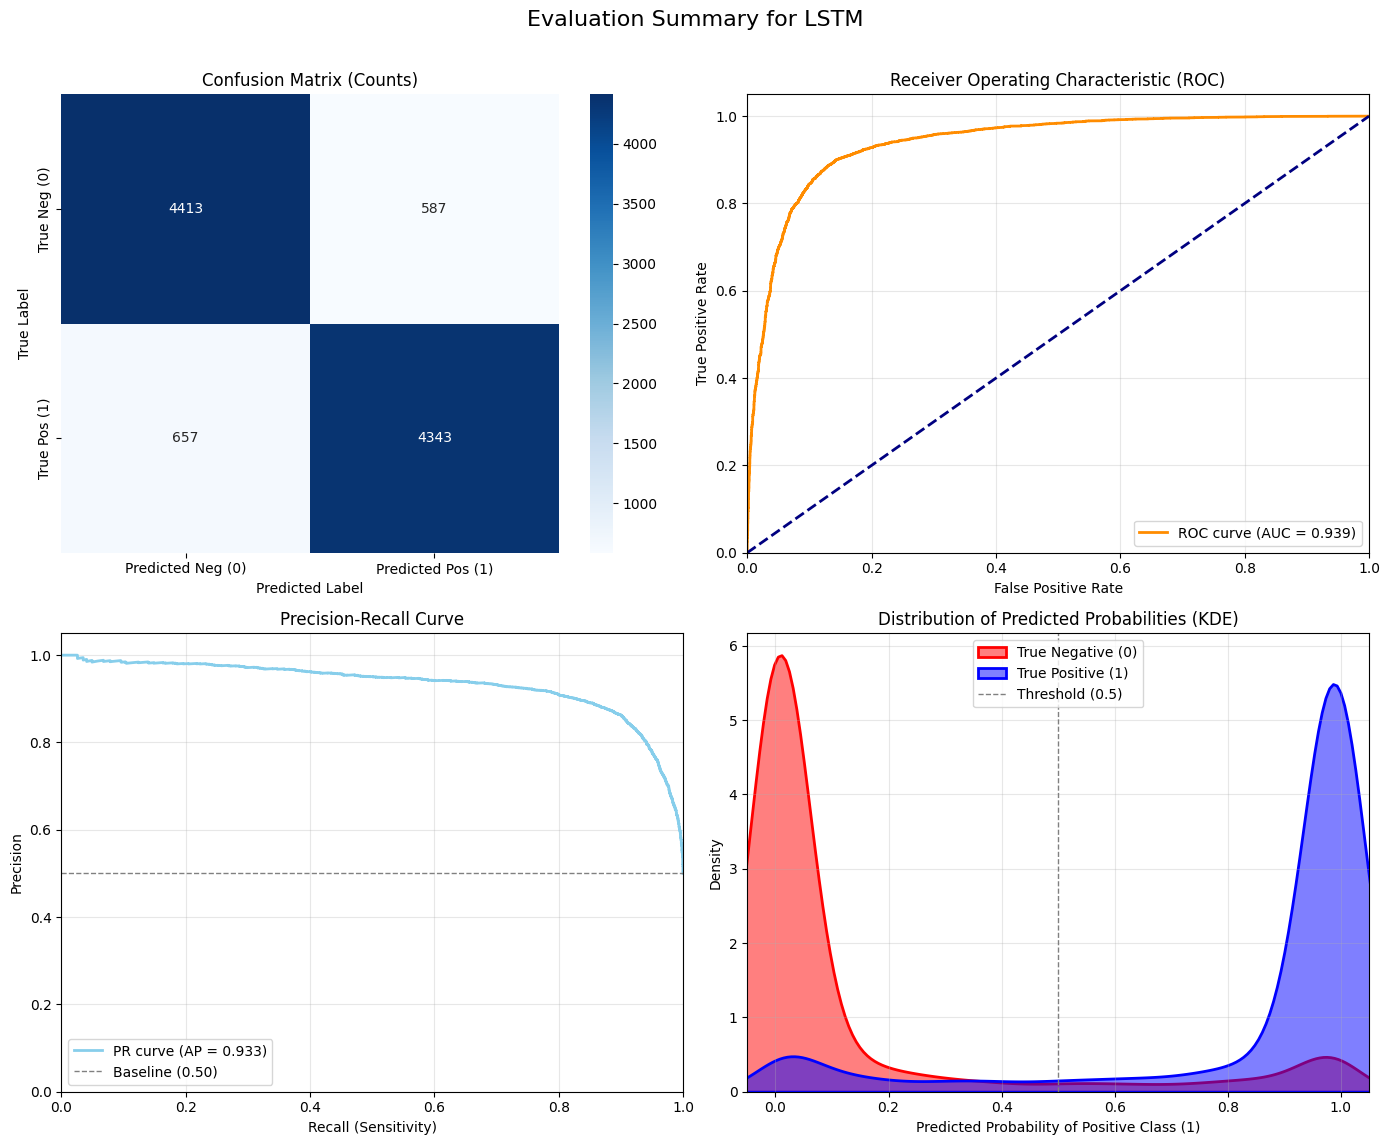

In [18]:
lstm_results, lstm_fig = evaluate_sequential_model(
                            final_lstm_model,
                            X_test_pad, # Pass the padded sequences
                            y_test,
                            model_name="LSTM",
                            batch_size=BATCH_SIZE_LSTM # Use appropriate batch size
                        )
if lstm_fig:
     plt.show() # Display the plot

The LSTM model achieved an accuracy of **87.56%** on the unseen test data, which indicates strong performance and good generalisation on unseen data (slightly worse than oru cnn model).

Looking at the confusion matrix, the LSTM model is able to identify a relatively large number of both and positive and negative reviews. The errors (FN, FP) are quite balanced and significantly smaller thatn the correct predictions, indicating good overall classification ability.

Based on the ROC curve, we have an AUC=0.939, suggesting that the model is capable of distinguishing between positive and negative classes.

Our precision-recall curve shows that the curve remains high even as recall increases, only dropping significantly at very high recall values. The average precision of 0.933 also affirms that the model maintians high precision when identifying a large proportion of true positive reviews.

The Kernel Density Estimate on the bottom right demonstrates how the model's predicted probabilites are distributed for samples that are truly negative versus those that are truly positive. There is a clear distinction between the two distributions, albeit some overlap and errors but they are relatively low density. In contrast, the narrow peaks indicate that the LSTM model is generally confident in its predictions.